# The Crypto Detective

Richard -> Critical Mission
Needs my help (really?)

Investigating potential fraud in crypto transactions.

Richard has an anonymous dataset of Crypto X filled with transaction details that might hide secrets about financial misconduct.

Be he can't crack this puzzle alone. He's looking a skilled data scientist (then why me?)

`Challenge`: Can you dive into this dataset and help him separate legitimate transactions from suspicious ones? He believes the right analysis could protect countless investors from potential financial risks.

Challenge Accepted!

### `4.1`: Preprocessing and Exploratory Data Analysis

In [13]:
import pandas as pd

train_data = pd.read_csv('data/train_data.csv')
val_data = pd.read_csv('data/val_data.csv')
test_data = pd.read_csv('data/test_data.csv')

print(train_data.isnull().sum())
print(val_data.isnull().sum()) 
print(test_data.isnull().sum())

Address                                                 0
FLAG                                                    0
Avg min between sent tnx                                0
Avg min between received tnx                            0
Time Diff between first and last (Mins)                 0
Unique Received From Addresses                          0
min value received                                      0
max value received                                      0
avg val received                                        0
min val sent                                            0
avg val sent                                            0
total transactions (including tnx to create contract    0
total ether received                                    0
total ether balance                                     0
dtype: int64
Address                                                 0
FLAG                                                    0
Avg min between sent tnx                                0
A

In [14]:
print("\nFor the Train Data:-")
print(len(train_data))
train_data.dropna(inplace=True)
print(len(train_data))

print("\nFor the Val Data:-")

print(len(val_data))
val_data.dropna(inplace=True)
print(len(val_data))

print("\nFor the Test Data:-")
print(len(test_data))
test_data.dropna(inplace=True)
print(len(test_data))


For the Train Data:-
9059
9059

For the Val Data:-
2265
2265

For the Test Data:-
2831
2831


In [15]:
# address needs to be drop because it is an identifier
train_data.drop(columns=["Address"], inplace=True)
val_data.drop(columns=["Address"], inplace=True)
test_data.drop(columns=["Address"], inplace=True)

In [16]:
# scaling features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features = train_data.drop(columns=["FLAG"])

scaled_features = scaler.fit_transform(features)

In [17]:
train_data

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
0,1,333.22,1836.33,157384.67,66,0.018293,1.609584,0.264718,0.009007,0.335513,134,19.853878,0.058596
1,1,0.00,269.50,206082.30,10,0.088038,2.030283,0.790670,7.905838,7.905838,11,7.906699,0.000861
2,0,6180.19,3503.34,551924.28,14,0.002108,15.000000,3.704406,0.000000,1.856308,101,100.018959,-37.347870
3,0,0.00,47.60,475945.68,4594,0.000000,0.103400,0.000069,0.000000,0.000000,10000,0.692556,0.692556
4,0,0.00,1955.01,226781.43,3,0.000000,0.463344,0.233199,0.000000,0.000000,117,27.051093,27.051093
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9054,0,30811.80,22.16,154103.30,1,0.010000,0.100000,0.055000,0.000000,0.021415,7,0.110000,0.002926
9055,0,41372.51,10604.71,575934.70,3,0.018324,8.688480,0.480539,0.043782,1.694857,34,12.974546,1.110544
9056,0,0.79,5058.21,25295.02,2,0.033105,0.563021,0.332478,0.032265,0.331638,10,1.662388,0.004200
9057,0,161.50,0.00,323.00,1,101.000000,101.000000,101.000000,8.999454,50.499508,3,101.000000,0.000984


In [18]:
feature_names = ["Abg min between sent tnx", "Avg min between received tnx", "Time Diff between first and last (Mins)", "Unique Received From Addresses", "min value received", "max value received", "avg val received", "min val sent", "avg val sent", "total transactions (including tnx to create contract)", "total ether received", "total ether balance"]

### Correlation matrix for the 12 features - excluding FLAG and Address 

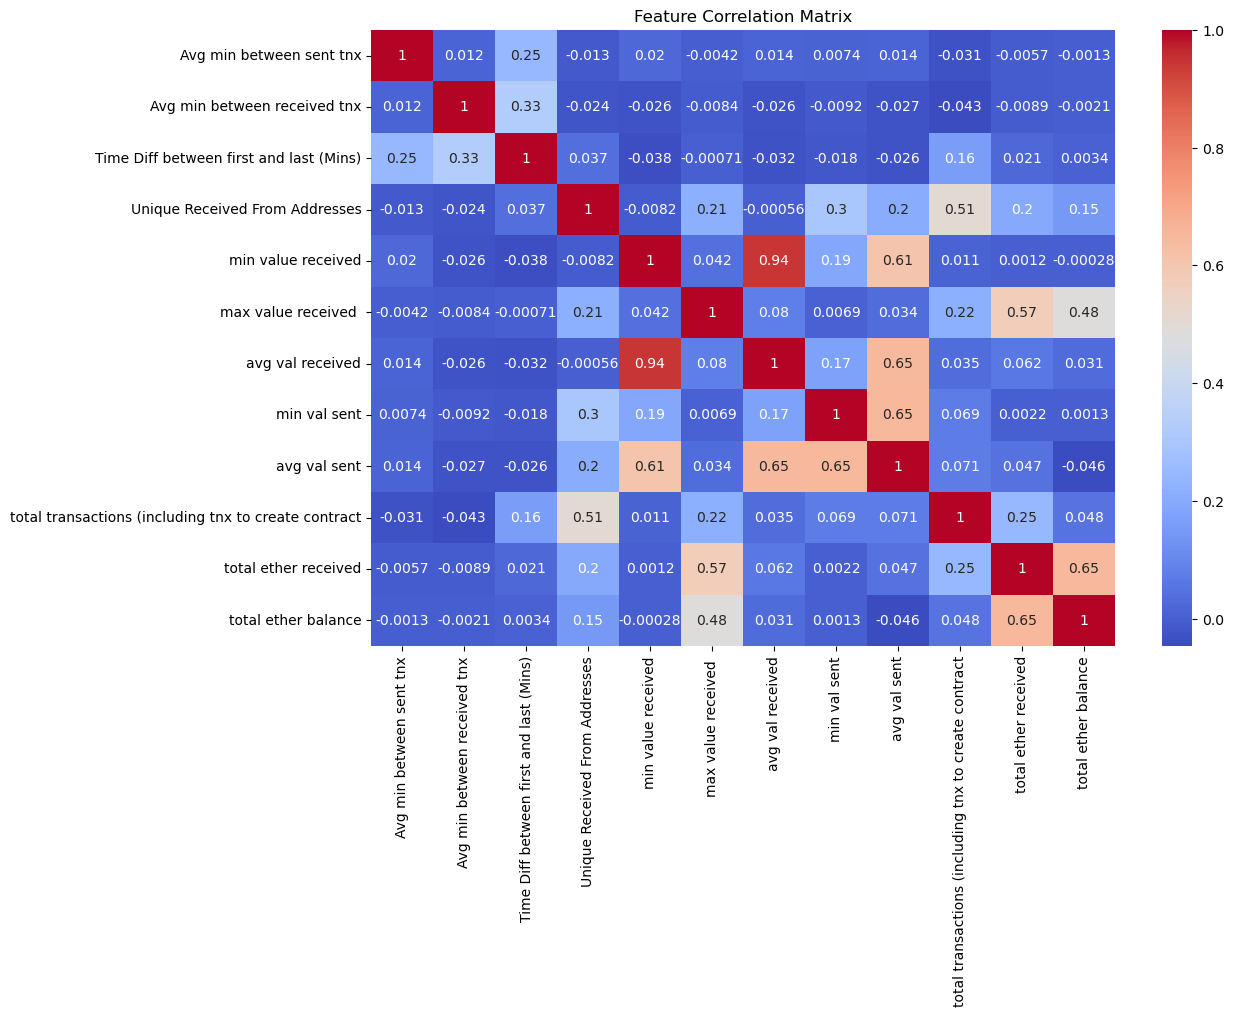

In [19]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(scaled_features, columns=features.columns).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

### Correlation matrix for the 13 features - excluding Address 

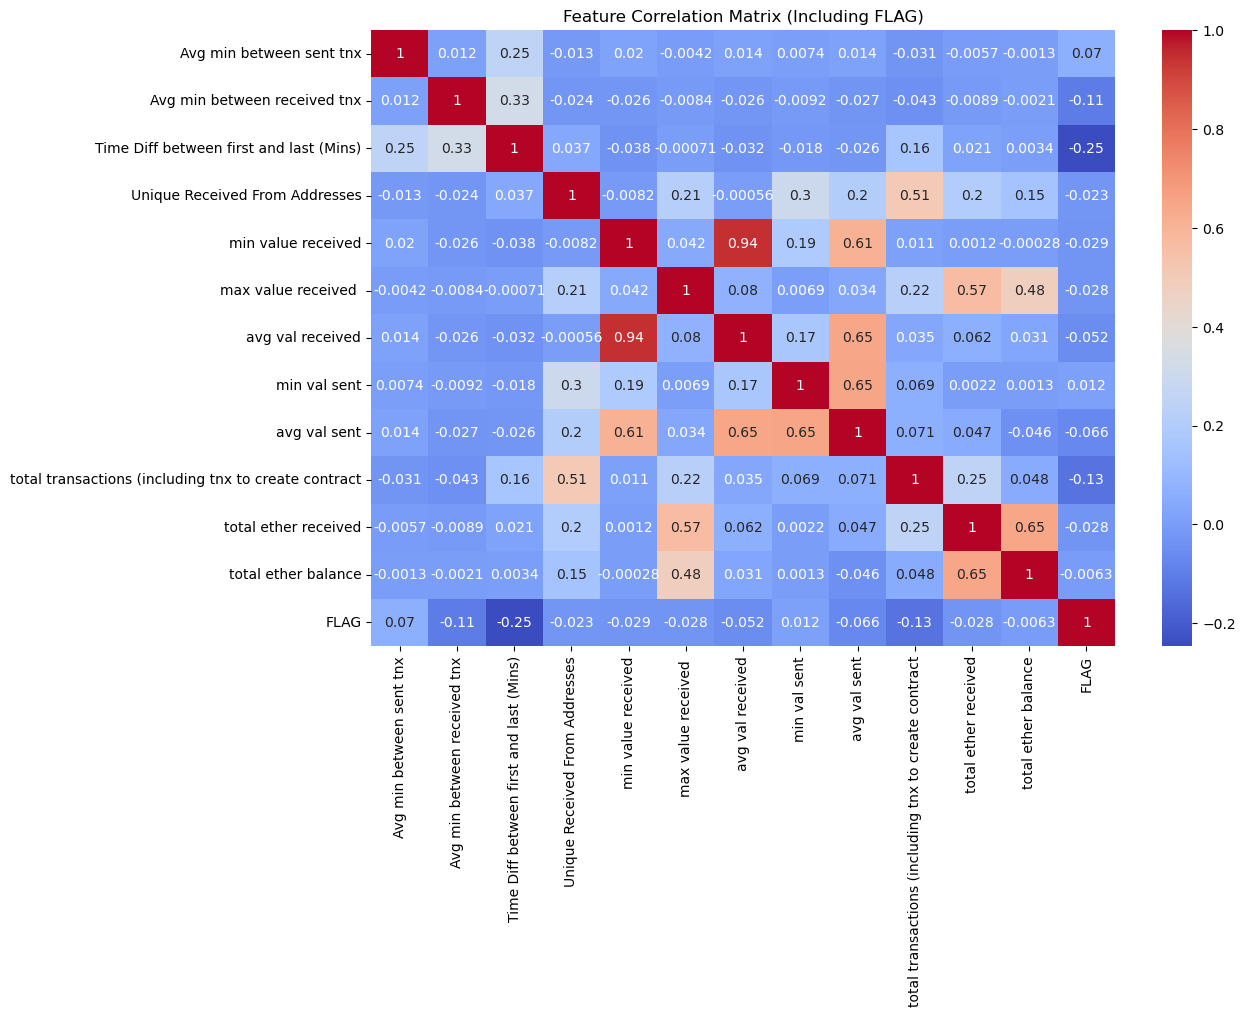

In [20]:
plt.figure(figsize=(12, 8))
corr_matrix = pd.DataFrame(scaled_features, columns=features.columns)
corr_matrix["FLAG"] = train_data["FLAG"]
sns.heatmap(corr_matrix.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix (Including FLAG)")
plt.show()

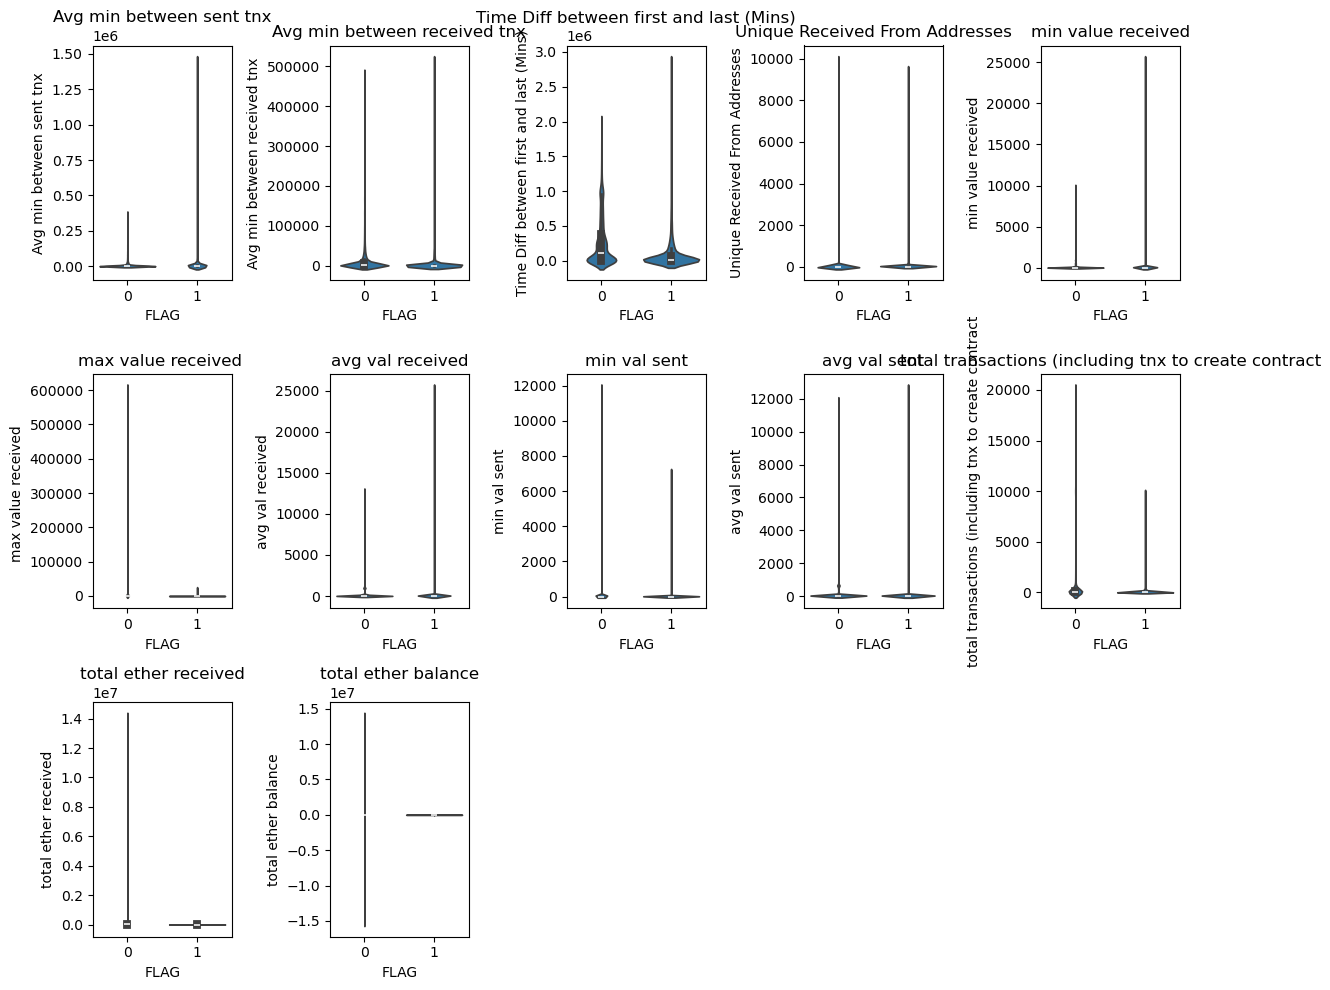

In [21]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(features.columns):
    plt.subplot(3, 5, i + 1)
    sns.violinplot(x=train_data["FLAG"], y=train_data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

### `4.2`: Fraud Detection Model

#### I am assuming binary split

In [22]:
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
import seaborn as sns

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, criterion="gini"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = None

        self.feature_importances_ = None

    def fit(self, X, y):
        self.feature_importances_ = np.zeros(X.shape[1])
        self.tree = self._grow_tree(X, y)
        
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)

    def _grow_tree(self, X, y, depth=0):
        if len(set(y)) == 1 or len(y) < self.min_samples_split or (self.max_depth and depth >= self.max_depth):
            return np.argmax(np.bincount(y))
        
        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return np.argmax(np.bincount(y))
        
        self.feature_importances_[best_feature] += self._calculate_impurity_reduction(X, y, best_feature, best_threshold)

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        left_subtree = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._grow_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {"feature": best_feature, "threshold": best_threshold, "left": left_subtree, "right": right_subtree}
    
    def _calculate_impurity_reduction(self, X, y, feature, threshold):
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        return self._information_gain(y, left_mask, right_mask)

    def _best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                if sum(left_mask) == 0 or sum(right_mask) == 0:
                    continue
                gain = self._information_gain(y, left_mask, right_mask)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold
    
    def _information_gain(self, y, left_mask, right_mask):
        def gini(y):
            proportions = np.bincount(y) / len(y)
            return 1 - np.sum(proportions ** 2)
        
        def entropy(y):
            proportions = np.bincount(y) / len(y)
            return -np.sum([p * np.log2(p) for p in proportions if p > 0])
        
        left_size = sum(left_mask)
        right_size = sum(right_mask)
        
        if self.criterion == "gini":
            parent_impurity = gini(y)
            left_impurity = gini(y[left_mask])
            right_impurity = gini(y[right_mask])
        elif self.criterion == "entropy":
            parent_impurity = entropy(y)
            left_impurity = entropy(y[left_mask])
            right_impurity = entropy(y[right_mask])
        else:
            raise ValueError("What more criterions can you think to have?!")

        weighted_impurity = (left_size * left_impurity + right_size * right_impurity) / len(y)
        return parent_impurity - weighted_impurity

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])
    
    def _traverse_tree(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node["feature"]] <= node["threshold"]:
            return self._traverse_tree(x, node["left"])
        else:
            return self._traverse_tree(x, node["right"])
        
    def plot_feature_importances(self):
        if self.feature_importances_ is not None:
            plt.figure(figsize=(10, 6))
            sns.barplot(x=np.arange(len(self.feature_importances_)), y=self.feature_importances_)
            plt.title("Feature Importances")
            plt.xlabel("Feature")
            plt.ylabel("Importance")
            plt.show()

    def plot_tree(self):
        dot = Digraph()
        self._add_nodes(dot, self.tree)
        dot.render("decision_tree", format="png", cleanup=True)
        dot.view("decision_tree")
        
    def _add_nodes(self, dot, node, parent=None, node_id=0):
        if not isinstance(node, dict):
            dot.node(str(node_id), label=str(node))
            if parent is not None:
                dot.edge(str(parent), str(node_id))
            return node_id + 1
        
        feature_name = f"Feature {node['feature']}"
        label = f"{feature_name}\nThreshold: {node['threshold']}"
        dot.node(str(node_id), label=label)
        
        if parent is not None:
            dot.edge(str(parent), str(node_id))
        
        left_id = self._add_nodes(dot, node["left"], node_id, node_id + 1)
        right_id = self._add_nodes(dot, node["right"], left_id, left_id + 1)
        
        return right_id


In [23]:
X_train = np.array(train_data.drop("FLAG", axis=1))
y_train = np.array(train_data["FLAG"])

X_val = np.array(val_data.drop("FLAG", axis=1))
y_val = np.array(val_data["FLAG"])

X_test = np.array(test_data.drop("FLAG", axis=1))
y_test = np.array(test_data["FLAG"])

In [24]:
print(X_train.shape)
print(y_train.shape)

(9059, 12)
(9059,)


In [25]:
import time

# change this later or the TAs might get furious
from sklearn.metrics import accuracy_score, classification_report

start_time = time.time()
d_tree = DecisionTree(max_depth=5, min_samples_split=10)
d_tree.fit(X_train, y_train)


In [13]:
preds_custom = d_tree.predict(X_train)
custom_time = time.time() - start_time
custom_acc = accuracy_score(y_train, preds_custom)
print("Decision Train Test Accuracy:", custom_acc)

preds_custom = d_tree.predict(X_test)
custom_time = time.time() - start_time
custom_acc = accuracy_score(y_test, preds_custom)
print("Decision Tree Test Accuracy:", custom_acc)

Decision Train Test Accuracy: 0.8754829451374324
Decision Tree Test Accuracy: 0.8777817025785941


Why is my train accuracy less than my test accuracy 😭

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

start_time = time.time()
sklearn_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
sklearn_tree.fit(X_train, y_train)
preds_sklearn = sklearn_tree.predict(X_train)
sklearn_time = time.time() - start_time
sklearn_acc = accuracy_score(y_train, preds_sklearn)
print("Scikit-Learn Decision Train Accuracy:", sklearn_acc)

start_time = time.time()
sklearn_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
sklearn_tree.fit(X_train, y_train)
preds_sklearn = sklearn_tree.predict(X_test)
sklearn_time = time.time() - start_time
sklearn_acc = accuracy_score(y_test, preds_sklearn)
print("Scikit-Learn Decision Test Accuracy:", sklearn_acc)

Scikit-Learn Decision Train Accuracy: 0.8754829451374324
Scikit-Learn Decision Test Accuracy: 0.8784881667255386


### `4.3`: Hyperparameter Tuning

In [19]:
## CAUTION TO TA: This will take a huge amount of time

max_depth_values = [1, 3, 5, 7, 10, None]
min_samples_split_values = [2, 5, 10, 20]
criteria = ["gini", "entropy"]

results = []

for criterion in criteria:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:

            model = DecisionTree(max_depth=max_depth, min_samples_split=min_samples_split, criterion=criterion)
            model.fit(X_train, y_train)
            
            # Validate model
            y_pred = model.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            
            results.append({
                "criterion": criterion,
                "max_depth": max_depth,
                "min_samples_split": min_samples_split,
                "accuracy": acc
            })


0
[3.33220e+02 0.00000e+00 6.18019e+03 ... 7.90000e-01 1.61500e+02
 2.78800e+01]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results)

# Plot accuracy trends
plt.figure(figsize=(10, 5))
for criterion in criteria:
    subset = results_df[results_df["criterion"] == criterion]
    plt.plot(subset["max_depth"].astype(str), subset["accuracy"], marker='o', label=f"{criterion} Impurity")

plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Decision Tree Accuracy vs Max Depth")
plt.legend()
plt.show()

best_model = results_df.loc[results_df["accuracy"].idxmax()]
print("Best Model Configuration:")
print(best_model)


Why do you think you obtained these results? Provide a possible explanation.

Explanation of the Results:

1. Effect of Max Depth

    Increasing depth improves accuracy up to a point but can lead to overfitting.

    A shallow tree may underfit, capturing only basic patterns.

2. Effect of Min Samples Split

    Larger values prevent excessive splits, reducing overfitting.
    Smaller values allow deeper trees, capturing more details but risking overfitting.

3. Gini vs. Entropy

    Entropy may work better on datasets with balanced class distributions.
    Gini is computationally faster but performs similarly in many cases.

### `4.4`: Model Visualization

`Feature Importance Visualization:`

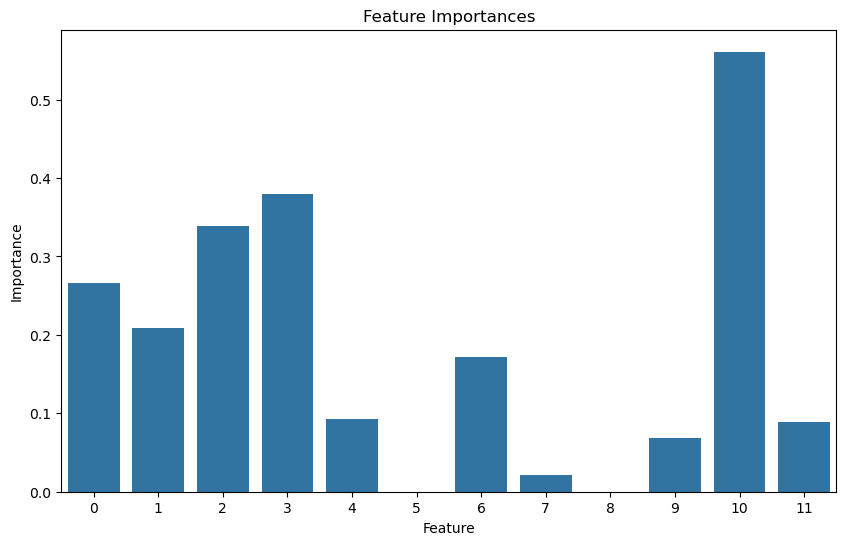

In [15]:
d_tree.plot_feature_importances()

`Tree Visualization:`

In [24]:
import matplotlib.pyplot as plt
import networkx as nx

# cause I am too lazy to get them automatically from the data
feature_names = ["Distance", "Weather", "Traffic Level", "Time of Day", "Vehicle Type", "Preparation Time", "Courier_Experience_yrs"] * 5

def plot_decision_tree(tree, feature_names=None):
    """
    Plots a binary tree representation of a trained DecisionTree.
    
    Parameters:
        tree (dict): The decision tree structure from DecisionTree class.
        feature_names (list): List of feature names corresponding to dataset columns.
    """
    if not isinstance(tree, dict):
        print("Invalid tree structure. Train the model first.")
        return

    G = nx.DiGraph()
    pos = {}
    labels = {}

    def add_edges(node, parent=None, pos_x=0, pos_y=0, depth=0):
        """ Recursively add nodes and edges to the graph. """
        node_id = str(id(node))  # Unique ID for each node
        pos[node_id] = (pos_x, -pos_y)  # Position for visualization

        if isinstance(node, dict):  # Internal node (split)
            feature = node["feature"]
            threshold = node["threshold"]
            feature_label = feature_names[feature] if feature_names else f"X[{feature}]"
            labels[node_id] = f"{feature_label} ≤ {threshold:.2f}"

            left_id = add_edges(node["left"], node_id, pos_x - 2**(-depth), pos_y + 1, depth + 1)
            right_id = add_edges(node["right"], node_id, pos_x + 2**(-depth), pos_y + 1, depth + 1)

            G.add_edge(node_id, left_id, label="True")
            G.add_edge(node_id, right_id, label="False")

        else:  # Leaf node (class prediction)
            labels[node_id] = f"Class {node}"

        return node_id

    root_id = add_edges(tree)

    # Draw the tree
    plt.figure(figsize=(30, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=2000, node_color="lightblue", edge_color="black", font_size=10)
    
    # Draw edge labels (True/False for left/right splits)
    edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title("Decision Tree Visualization")
    plt.show()

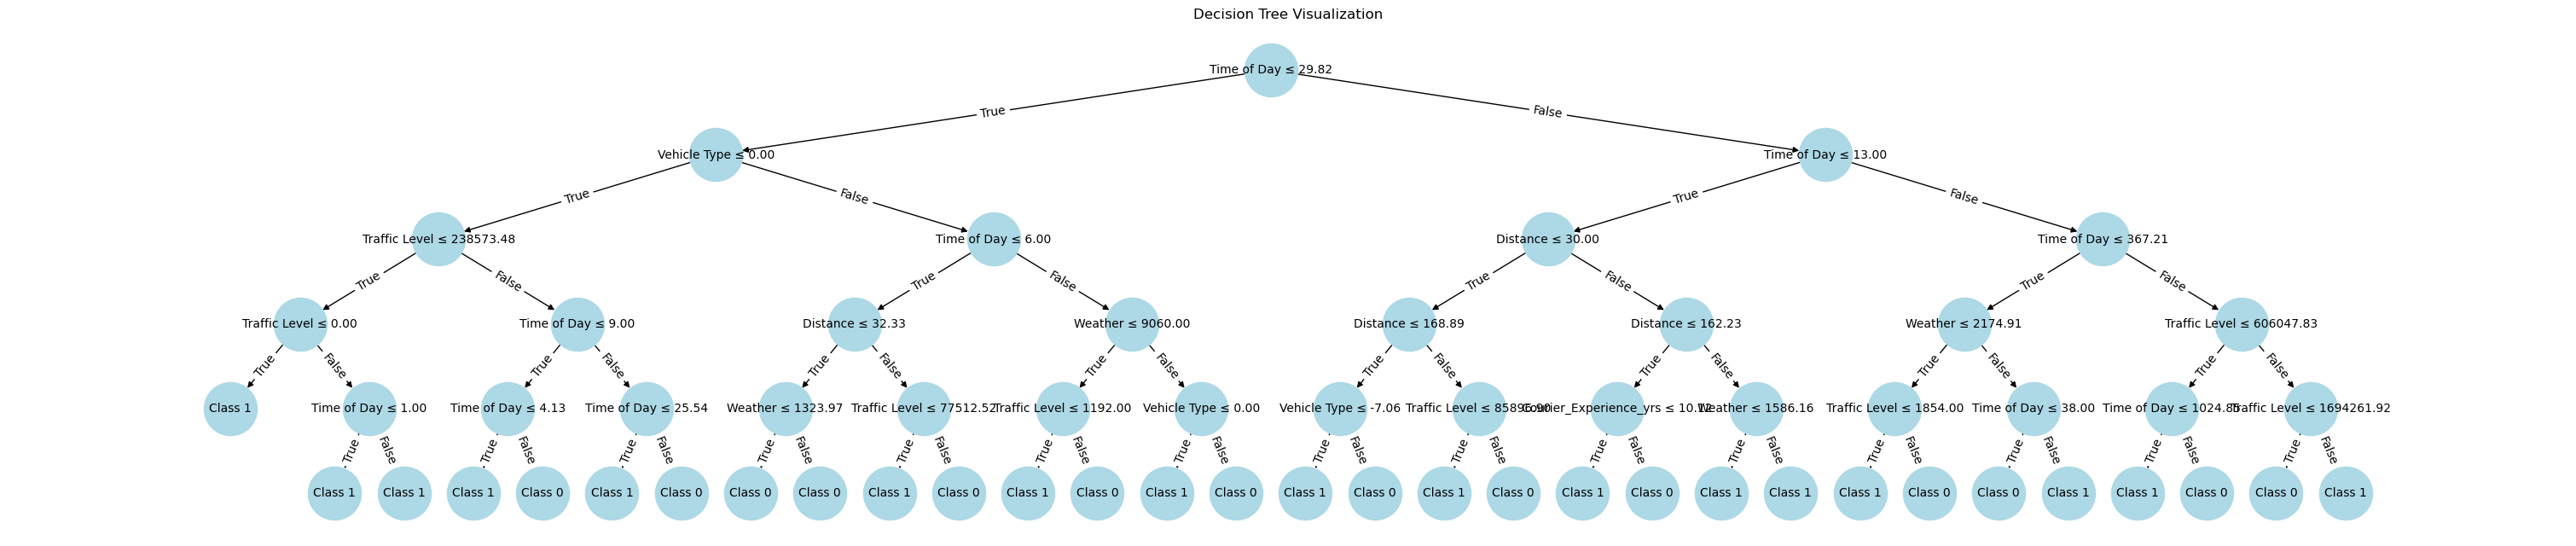

In [25]:
# Need to fix the visualisation

plot_decision_tree(d_tree.tree, feature_names)